# NEOphot: Extract NEO photometry from Spitzer data

## Joseph Hora
### Center for Astrophysics | Harvard & Smithsonian


In [1]:
# Import all necessary packages and functions

import numpy as np
import numpy.ma as ma
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.text import Text

plt.rcParams.update({'figure.max_open_warning': 0})

import glob
import re
import os
import sys
import shutil

# from astropy.utils.data import download_file
from astropy.io import fits
from matplotlib.colors import LogNorm
from astropy.io.fits import getval
from astropy.io.fits import getheader
from astropy.io.fits import getdata
from astropy.wcs import WCS
from astropy.wcs.utils import proj_plane_pixel_scales
from astropy.utils.exceptions import AstropyWarning
from astropy import units as u
from astropy.coordinates import SkyCoord

# photometry functions
from photutils.centroids import centroid_com
from image_registration import chi2_shift

# For mosaic construction
from reproject import reproject_interp
from reproject import reproject_adaptive
from reproject import reproject_exact
from reproject.mosaicking import reproject_and_coadd
from reproject.mosaicking import find_optimal_celestial_wcs
from astropy.stats import sigma_clip
from astropy.nddata import Cutout2D
from skimage.util.shape import view_as_windows

# Photometry
from astropy.stats import sigma_clipped_stats
from astropy.wcs import WCS
from photutils import datasets
from photutils import DAOStarFinder,aperture_photometry
from photutils import CircularAperture
from photutils import CircularAnnulus
from photutils.centroids import centroid_sources
from photutils.utils import calc_total_error

import requests
from scipy import stats
from tempfile import mkstemp
import warnings
from datetime import datetime

from NEOphot_funcs import (copy_headerlines,subframes, calculate_darkframe, get_median_limited, 
                           make_skymosaic, make_NEOmosaic, get_mosaicphot, get_BCDphot, eval_phot, 
                           getHorizonsQueryText, ADU2uJy, uJy2mag, write_BCDphot_output, plotRA_DEC, 
                           plotRA_DECch2, plot_phot, getNEOframes, update_refpos, plotskycoadds, 
                           plotNEOmosaics, plotdarkframes, plotSkymosaics)


C:\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
c:\temp\ipykernel_7000\1422104076.py:49: DeprecationWarning: `photutils.DAOStarFinder` is a deprecated alias for `photutils.detection.DAOStarFinder` and will be removed in the future. Instead, please use `from photutils.detection import DAOStarFinder` to silence this warning.
  from photutils import DAOStarFinder,aperture_photometry
c:\temp\ipykernel_7000\1422104076.py:49: DeprecationWarning: `photutils.aperture_photometry` is a deprecated alias for `photutils.aperture.aperture_photometry` and will be removed in the future. Instead, please use `from photutils.aperture import aperture_photometry` to silence this warning.
  from photutils import DAOStarFinder,aperture_photometry
c:\temp\ipykernel_7000\1422104076.py:50: DeprecationWarning: `photutils.CircularAperture` is a deprecated alias for `photutils.aperture.CircularAperture` and will 

In [2]:
# copy the results to another directory to collect them in one place
def copy_results():
    filenames = impath + r'*.csv'
    for file in glob.glob(filenames):
        shutil.copy2(file, resultsdir)
    filenames = impath + r'*.pdf'
    for file in glob.glob(filenames):
        shutil.copy2(file, resultsdir)
    filenames = impath + r'*.log'
    for file in glob.glob(filenames):
        shutil.copy2(file, resultsdir)
        
# delete the specified files 
def clean_datadir(filenames):
    filelist= glob.glob(filenames)
    if len(filelist)>0:
        for filepath in filelist:
            try:
                os.remove(filepath)
            except:
                print("Error while deleting file : ", filepath)

# Check if the position specified is within the array given
def positions_OK(pos, img):
    if np.isnan(pos[0]):
        return False
    elif np.isnan(pos[1]):
        return False
    elif (pos[0]>=0 and pos[0]<img.shape[1] and pos[1]>=0 and pos[1]<img.shape[0]):
        return True
    else:
        return False
    
# returns distance between NEO positions in frames in arcsec
def getNEOmotion(file1, file2):            
    c1 = SkyCoord(getval(file1,'RA_REF'), getval(file1,'DEC_REF'), unit="deg")
    c2 = SkyCoord(getval(file2,'RA_REF'), getval(file2,'DEC_REF'), unit="deg")
    return c1.separation(c2).value*3600

def onclick(event):
    print('%s click: button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
          ('double' if event.dblclick else 'single', event.button,
           event.x, event.y, event.xdata, event.ydata))

## Start of main program

In [3]:
# Initialize some items before running the main processing loops

versionnum = 1.2                            # version number of NEOphot software
versiondate = '2024/07/13'                  # Date of NEOPhot software version
warnings.simplefilter('ignore', category=AstropyWarning)

params={'legend.fontsize':'14','axes.labelsize':'14',
    'axes.titlesize':'14','xtick.labelsize':'14',
    'ytick.labelsize':'14','lines.linewidth':2,'axes.linewidth':2,'animation.html': 'html5'}
plt.rcParams.update(params)

## After starting program, enter first AOR directory below in AORcode

In [4]:
# Define the location and filenames to search for processing

import pathlib
workingdir = os.getcwd()
print('Working directory: ', workingdir)
config_fname =  '/NEOphot_config_Forge.txt'

if os.path.exists(workingdir + config_fname):                 # If config file exists, read the directory
    print('Reading configuration file:')                     # location from the file
    with open(workingdir + config_fname) as f:
        content_list = [line.rstrip() for line in f]
    rootdir = content_list[0]
    resultsdir = content_list[1]
    print(rootdir)
    print(resultsdir)
else:
    rootdir = 'e:/YORPD/data/P70054/'                         # location of AOR data files
    resultsdir = 'e:/YORPD/results/'                          # location where results of reduction are copied to

bothchan = False            # process the NEO data for both channel 1 (3.6 um and channel 2 (4.5 um)

debug = False               # set "True" to write mask files and print other diagnostic information
moswl = 301                 # size of NEO mosaic, make it an odd number (subpixels)
use_subframes = True            # subtract sky from BCDs before doing photometry and making NEO mosaic
sub_dark = True             # calculate and subtract dark frame from data

# Make a list of all of the AORs in the data directory. Start processing with the AORCode defined
# below, and then after it is complete, set the AORcode to the next AOR on that list (see the
# following cell and the cell at the end of the processing section). To override this, uncomment 
# and set the AORcode in the cell below to the desired directory to process.


AORlist = glob.glob(rootdir+'r*')
AORlist.sort()
AORlist =[i.replace('\\', '/') for i in AORlist]

AORcode = AORlist[0][(AORlist[0].rfind('/')+1):]

if os.path.exists('nextAORdir.txt'):
    print('Reading nextAORdir.txt file:')
    with open('nextAORdir.txt') as f:
        content_list = [line.rstrip() for line in f]
    AORcode = content_list[0]

nextAOR = AORcode
print(nextAOR)

Working directory:  C:\Users\Joseph Hora
Reading configuration file:
h:/YORPD/data_13006/
h:/YORPD/results_redo/
Reading nextAORdir.txt file:
r61782272


# Start AOR processing here 
<a id='StartProcessing'></a>

In [87]:
# Get lists of files, ITIME to use, object name and SPK number
AORcode = nextAOR                    # For proceeding automatically to the next AOR in data directory
# AORcode = "r52384256"              # Use this line to force a particular AOR

moswl = 301                          # size of NEO mosaic, make it an odd number (subpixels)
get_ipython().run_line_magic('matplotlib', 'inline')
impath = rootdir + AORcode + '/'
refine_NEOpos = False                # Query Horizons for the predicted RA, Dec of the NEO for each observation
useallBCDs = False                   # Use every BCD in NEO mosaic to increase S/N if not visible in BCDs

if bothchan:
    f1list = glob.glob(impath + 'ch1/bcd/*cbcd.fits')
f2list = glob.glob(impath + 'ch2/bcd/*cbcd.fits')
itime=0

f2list.sort()
ch1filelist = []
ch2filelist = []

for filename in f2list:               # Find longest frametime in set to use for mosaics/photometry
    fileframetime = getval(filename,'FRAMTIME')
    if fileframetime > itime:
        itime = fileframetime
if bothchan:
    f1list.sort()
    for filename in f1list:
        if getval(filename,'FRAMTIME') == itime:
            ch1filelist.append(filename)
for filename in f2list:
    if getval(filename,'FRAMTIME') == itime:
        ch2filelist.append(filename)
if bothchan:
    fulllist = ch1filelist + ch2filelist
else:
    fulllist = ch2filelist

if bothchan:
    ch1filelist_all = ch1filelist.copy()
ch2filelist_all = ch2filelist.copy()

max_NEO_separation = getNEOmotion(ch2filelist[0], ch2filelist[-1])
elapsed_time = getval(ch2filelist[-1],'ATIMEEND') - getval(ch2filelist[0],'AINTBEG')

# Find object name (in format YYYY_aa) in the data file header
AORlabel = getval(ch2filelist[0],'AORLABEL')
objectname = AORlabel[AORlabel.find('(')+1:AORlabel.find(')')]

objectname = getval(ch2filelist[0],'OBJECT')
objectname = objectname.replace("(","")
objectname = objectname.replace(")", "")
objectname = objectname.replace(" ","_") + "_"+ AORcode

# If object name is not present, query user for the name
if len(objectname)<6:               
    print("Object name not in AORLABEL: ",AORlabel)
    objectname = input("Enter object name (e.g., YYYY_aa): ")
elif objectname.find('[')>-1:
    objectname = objectname[:objectname.find('[')-1]
ephfile = getval(ch2filelist[0], 'EPHMFILE')
SPK = ephfile[:ephfile.find('.')]

# set minimum image standard deviation for NEOmosaic based on frame time
if itime==12:           
    std_base = 0.15
elif itime==30:
    std_base = 0.05
elif itime == 100:
    std_base = 0.025
elif itime == 2.0:
    std_base = 0.3
elif itime == 6.0:
    std_base = 0.2
else:
    print("warning: nonstandard time")
    std_base = 0.01

dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime("%Y-%b-%d (%H:%M:%S.%f)")
rootname = impath + objectname
mosnum = 0                                 # mosnum increments automatically to process next batch
                                           # of BCDs if there are multiple sets for an object

# Print some information on the data set to be processed
print("Dataset parameters:")
    
outline = AORcode + '  Object: '+ objectname + '  SPK: '+ SPK + '  FRAMTIME: '+ str("%6.1f" % itime)
outline = outline + '   Nframes: ' + str("%i" % len(ch2filelist))
print(outline)
logfile = open(impath + objectname + "_info.log", "w")
logfile.write("Reduction of Spitzer/IRAC NEO data, using NEOphot version "+
              str("%5.2f\n" % versionnum))
logfile.write("Data directory: "+rootdir+AORcode+"\n")
logfile.write("Start time of reduction: "+timestampStr+"\n\n")
logfile.write(outline + '\n')
outline = "Total elapsed time during observation:" + str("%8.3f seconds" % elapsed_time)
print(outline)
logfile.write(outline + '\n')
outline = "Total motion of NEO during observation in each channel:"
outline = outline + str("%8.3f arcsec" % max_NEO_separation)
print(outline)
logfile.write(outline+'\n\n')

if max_NEO_separation<10:
    print("\n\n\033[91m WARNING: NEO separation <10 arcsec, adjust the mradius to not mask all sky below NEO\n\n")

Dataset parameters:
r61783552  Object: 388188_2006_DP14_r61783552  SPK: 2388188  FRAMTIME:  100.0   Nframes: 60
Total elapsed time during observation:6617.700 seconds
Total motion of NEO during observation in each channel: 415.228 arcsec


### For multiple mosaics per AOR, restart process in cell below

In [88]:
# Set output names. If Nimages>100, then process only the set defined by mosnum and num_per_mosaic
# Process all frames by running this cell through the end multiple times until all frames processed.

totnumframes = len(ch2filelist_all)
maxframes = 150
if totnumframes>maxframes:
    if mosnum == 0:
        num_per_mosaic = int(totnumframes/(int(totnumframes/maxframes)+1))
        number_of_mosaics = int(totnumframes/num_per_mosaic)
        while number_of_mosaics*num_per_mosaic<totnumframes:
            num_per_mosaic = num_per_mosaic + 1
        outline = "Breaking up job into "+str("%2i" % number_of_mosaics)+" of mosaics with " 
        outline = outline + str("%3i" % num_per_mosaic)+ " frames per mosaic"
        print(outline)
        logfile.write('\n' + outline + '\n')
    else:
        outline = "Processing mosaic number "+str("%2i" % (mosnum+1))+" of "+str("%2i" % number_of_mosaics)+" mosaics"
        print(outline)
        logfile.write(outline + '\n\n')
    do_mult_mos = True
    logfile.write('\nSky mosaic/photometry set '+str('%1i\n\n' % mosnum))
    I1skymosname = rootname + '_I1skymos_' + str('%1i' % mosnum)+'.fits'
    I1skycoadname = rootname + '_I1skycoadd_' + str('%1i' % mosnum)+'.fits'
    I2skymosname = rootname + '_I2skymos_' + str('%1i' % mosnum)+'.fits'
    I2skycoadname = rootname + '_I2skycoadd_' + str('%1i' % mosnum)+'.fits'
    if bothchan:
        ch1filelist = []
    ch2filelist = []
    for i in range(totnumframes):
        if i>=mosnum*num_per_mosaic and i<(mosnum+1)*num_per_mosaic:
            if bothchan:
                ch1filelist.append(ch1filelist_all[i])
            ch2filelist.append(ch2filelist_all[i])
    if bothchan:
        fulllist = ch1filelist + ch2filelist
    else:
        fulllist = ch2filelist.copy()
else:
    do_mult_mos = False
    mosnum = 0
    I1skymosname = rootname + '_I1skymos.fits'
    I1skycoadname = I1skymosname[:I1skymosname.rfind('mos.fits')] + 'coadd.fits'
    I2skymosname = rootname + '_I2skymos.fits'
    I2skycoadname = I2skymosname[:I2skymosname.rfind('mos.fits')] + 'coadd.fits'


C:\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


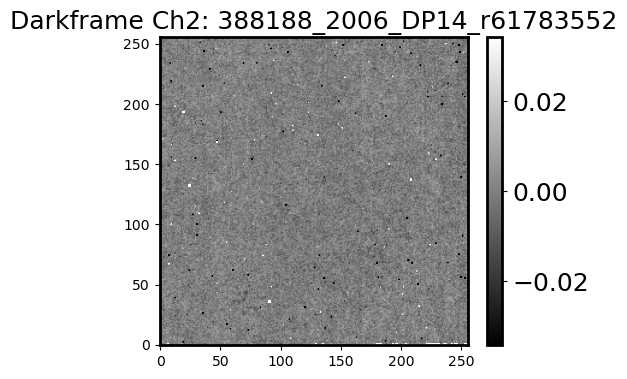

In [89]:
# Calculate the dark frame from the dataset

darkframe2 = ''
darkframe1 = ''

if sub_dark:
    logfile.write("Dark frames calculated and subtracted from BCDs\n\n")
    if do_mult_mos:
        if bothchan:
            darkframe1 = calculate_darkframe(ch1filelist,
                                             rootname + 'I1_' + str('%1i' % mosnum)+'_dark.fits', 
                                             versionnum, versiondate)
        darkframe2 = calculate_darkframe(ch2filelist,
                                         rootname + 'I2_' + str('%1i' % mosnum)+ '_dark.fits', 
                                         versionnum, versiondate)
    else:
        if bothchan:
            darkframe1 = calculate_darkframe(ch1filelist, rootname + 'I1dark.fits',
                                             versionnum, versiondate)
        darkframe2 = calculate_darkframe(ch2filelist, rootname + 'I2dark.fits',
                                         versionnum, versiondate)
    plotdarkframes(bothchan, objectname, impath, darkframe1, darkframe2)

In [90]:
# Find a WCS for the mosaic and the subtracted frames

wcs_out, shape_out = find_optimal_celestial_wcs(fulllist, auto_rotate=True, resolution = 0.6*u.arcsec)
# wcs_out.to_header() 
print('Size of sky mosaic: ',shape_out[0],'x',shape_out[1])


Size of sky mosaic:  829 x 1319


In [91]:
# recalculate RA_REF and DEC_REF positions (location of NEO in frame) using Horizons query
if refine_NEOpos:
    BCDsfx = 'cbcdc.fits'
    getHorizonsQueryText(ch2filelist,itime,SPK)
    f = open('HORIZONS.txt')
    url = 'https://ssd.jpl.nasa.gov/api/horizons_file.api'
    r = requests.post(url, data={'format':'text'}, files={'input': f})
#     print(r.text)
    datafound = False
    refpositions = []
    for line in r.text.splitlines():
        if not datafound:
            if line.find('$$SOE')>-1:
                datafound = True
        elif line.find('$$EOE')>-1:
            datafound = False
        else:
            JDtime, RAref, DEref, a1, a2, a3, a4, a5, a6, a7, a8, a9=  line.split()
            if debug:
                print(JDtime, RAref, DEref)
            refpos = (RAref, DEref)
            refpositions.append(refpos)

    # make new set of BCD files with updated reference positions of NEO
    newch1flist = []
    newch2flist = []
    for i in range(len(refpositions)):
        if bothchan:
            newch1flist.append(update_refpos(ch1filelist[i], refpositions[i][0], refpositions[i][1]))
        newch2flist.append(update_refpos(ch2filelist[i], refpositions[i][0], refpositions[i][1]))
else:
    BCDsfx = 'cbcd.fits'
    newch1flist = ch1filelist.copy()
    newch2flist = ch2filelist.copy()
    
mshift = (0, 0)                   # set offset if NEO not at predicted position


## Sky mosaic calculation
### Set "mshift" vector below to (0,0) if offset is unknown, turn sky subtraction on/off

In [93]:
# Make sky mosaic (masking NEO out)

# Get mshift parameters after first running the BCD photometry step below to get
# the median offset of the NEO position relative to the predicted position

# mshift = (3.2050191367007983, 8.730707833545978)                  # set offset if NEO not at predicted position

mradius = 7                      # radius of NEO masking
# mradius = 0                       # radius of NEO masking set to zero for small motion of NEO in frame set
use_mask = True                   # use pipeline-produced mask frames before making images/doing photometry
firstboxsize = 15                 # size of region used to centroid on NEO during BCD photometry

refnum = int(len(ch2filelist) / 2) + 1

logfile.write("Sky Mosaic parameters:\n")
logfile.write(" Radius of mask around NEO: "+ str("%2i\n" % mradius) +
             " Shift relative to nominal location: " + str("(%2i," % mshift[0]) +
             str("%2i)\n\n" % mshift[1]) )

if bothchan:
    projlist1 = make_skymosaic(newch1flist, mradius, mshift, I1skymosname,
                               I1skycoadname, refnum, std_base, wcs_out, shape_out,
                               darkframe1, sub_dark, use_mask, BCDsfx, versionnum, versiondate)
    plotskycoadds(impath, I1skycoadname, objectname, do_mult_mos, mosnum)
    
    print("Ch1 sky mosaic name: ", I1skymosname)
    
projlist2 = make_skymosaic(newch2flist, mradius, mshift, I2skymosname,I2skycoadname,
                           refnum, std_base, wcs_out, shape_out, darkframe2,
                           sub_dark, use_mask, BCDsfx, versionnum, versiondate)

pixelscales = proj_plane_pixel_scales(WCS(getheader(projlist2[0])))*3600   #arcsec/pixel of images

# Show the central part of the coadd image to see the number of frames used in sky mosaic there
plotskycoadds(impath, I2skycoadname, objectname, do_mult_mos, mosnum)
print("Ch2 sky mosaic name: ", I2skymosname)

# Show the sky mosaics
plotSkymosaics(I1skymosname, I2skymosname, bothchan, std_base, impath, objectname, mosnum, do_mult_mos)

C:\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
C:\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Joseph Hora\NEOphot_funcs.py:289: RuntimeWarning: Mean of empty slice
  fprint_concat = []


Ch2 sky mosaic name:  h:/YORPD/data_13006/r61783552/388188_2006_DP14_r61783552_I2skymos.fits


In [97]:
# Subtract the sky mosaic from each of the BCD images in the reference frame of the sky mosaic
# use_subframes = False            # do not subtract sky from BCDs before doing photometry and making NEO mosaic
use_subframes = True               # subtract sky from BCDs before doing photometry and making NEO mosaic
firstboxsize = 11                  # size of centroid box for photometry from BCDs

if use_subframes:
    if bothchan:
        subframelist1 = subframes(projlist1, I1skymosname, wcs_out, shape_out, 
                                  objectname, versionnum, versiondate)
    subframelist2 = subframes(projlist2, I2skymosname, wcs_out, shape_out, 
                              objectname, versionnum, versiondate, useall=True)
else:
    subframelist1 = []
    subframelist2 = []
    if bothchan:
        for image in projlist1:
            if getval(image,'NEOFRAME')==1:
                subframelist1.append(image)
    for image in projlist2:
        if getval(image,'NEOFRAME')==1:
            subframelist2.append(image)

In [98]:
# Perform photometry on BCD frames in channel 1
if bothchan:
    %matplotlib inline
    
    if len(subframelist1)>0:
        photlist1, times, fluxes, badtimes, badflux, xreloff, yreloff, xshift1, yshift1, errest1 = get_BCDphot(subframelist1, 
                            firstboxsize, mshift, do_mult_mos, impath, objectname, mosnum, logfile)
    else:
        print("Warning: no Ch1 frames in subframelist")



In [99]:
# Evaluate the photometry, add or subtract bad photometry from the list

# Evaluate Channel 1 photometry if present

if bothchan:
    if len(photlist1)>0:
        BCDphot1, errest1, gxro1, gyro1, badtimes1, badflux1 = eval_phot(photlist1, times, fluxes,
                badtimes, badflux, xreloff, yreloff, objectname, 1, xshift1, yshift1, do_mult_mos, impath)
    else:
        print("Error - no valid Ch1 photometry")
    
    gxro1 = np.asarray(gxro1) * float(pixelscales[0])
    gyro1 = np.asarray(gyro1) * float(pixelscales[1])
    distrads1 = np.sqrt(gxro1**2 + gyro1**2)
    disterr1 = np.std(distrads1)
else:
    BCDphot1 = []

In [100]:
# Output the Ch1 photometry to a file

if bothchan:
    # Output results from above cell
    print("Ch1 position error: ", str("%5.3f" % disterr1))
    logfile.write("Ch1 position error: "+ str("%5.3f\n" % disterr1))
    outfile = impath + objectname + "_ch1.csv"
    if do_mult_mos:
        goodfluxes1, raoffsets1, decoffsets1 = write_BCDphot_output(outfile,
                                            BCDphot1, errest1, objectname, SPK, 1, overwrite=False)
    else:
        goodfluxes1, raoffsets1, decoffsets1 = write_BCDphot_output(outfile, 
                                            BCDphot1, errest1, objectname, SPK, 1)

    if len(goodfluxes1)>0:
        BCDphotmean1 = np.mean(goodfluxes1)
        BCDphotstd1 = np.std(goodfluxes1)
        ramedoff = np.median(raoffsets1)
        decmedoff = np.median(decoffsets1)
        rastdoff = np.std(raoffsets1)
        decstdoff = np.std(decoffsets1)
        outline = "Ch1 mean BCD flux: " + str("%6.3f " % BCDphotmean1) + str(" std: %5.3f" % BCDphotstd1)
        print('\n\n',outline)
        logfile.write(outline + '\n')
        print(" Ch1 mean BCD mag: " + str("%5.3f, err=" % uJy2mag(1,BCDphotmean1)), str("%4.2f" % (BCDphotstd1/BCDphotmean1)))
        outline = " Ch1 RA median offset: "+ str("%6.3f " % ramedoff) + str(" std: %5.3f" % rastdoff)
        print(outline)
        logfile.write(outline + '\n')
        outline = " Ch1 Dec median offset: "+ str("%6.3f " % decmedoff) + str(" std: %5.3f" % decstdoff)
        print(outline)
        logfile.write(outline + '\n\n')
    else:
        BCDphotmean1 = 0
        BCDphotstd1 = 0
        outline = 'No Ch1 BCD photometry results'
        print('\n\n',outline)
        logfile.write(outline + '\n\n')


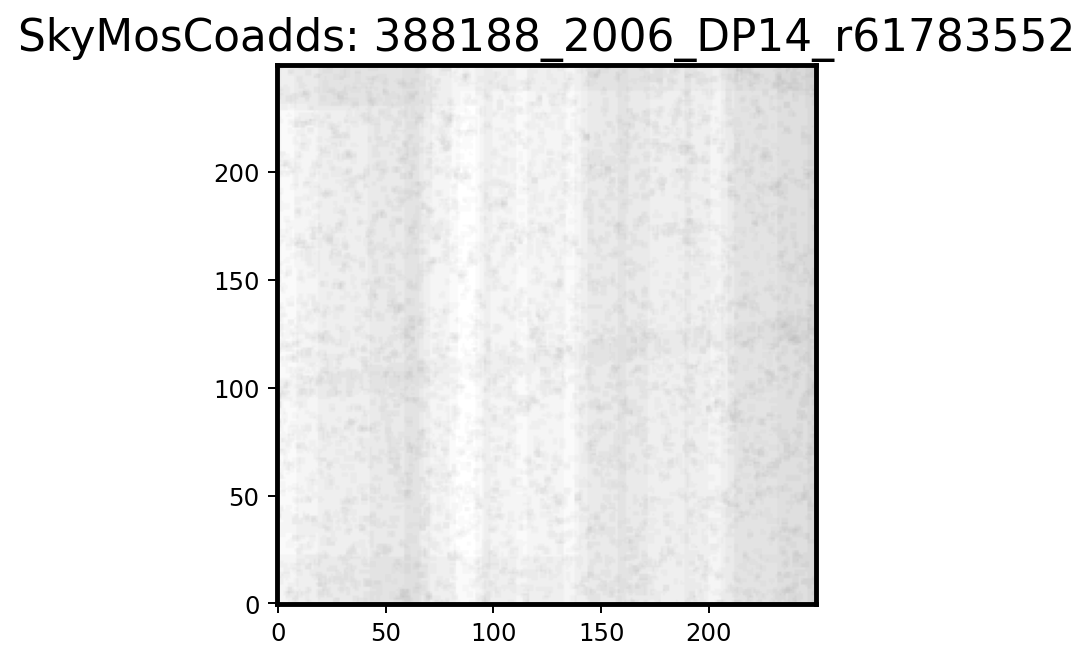

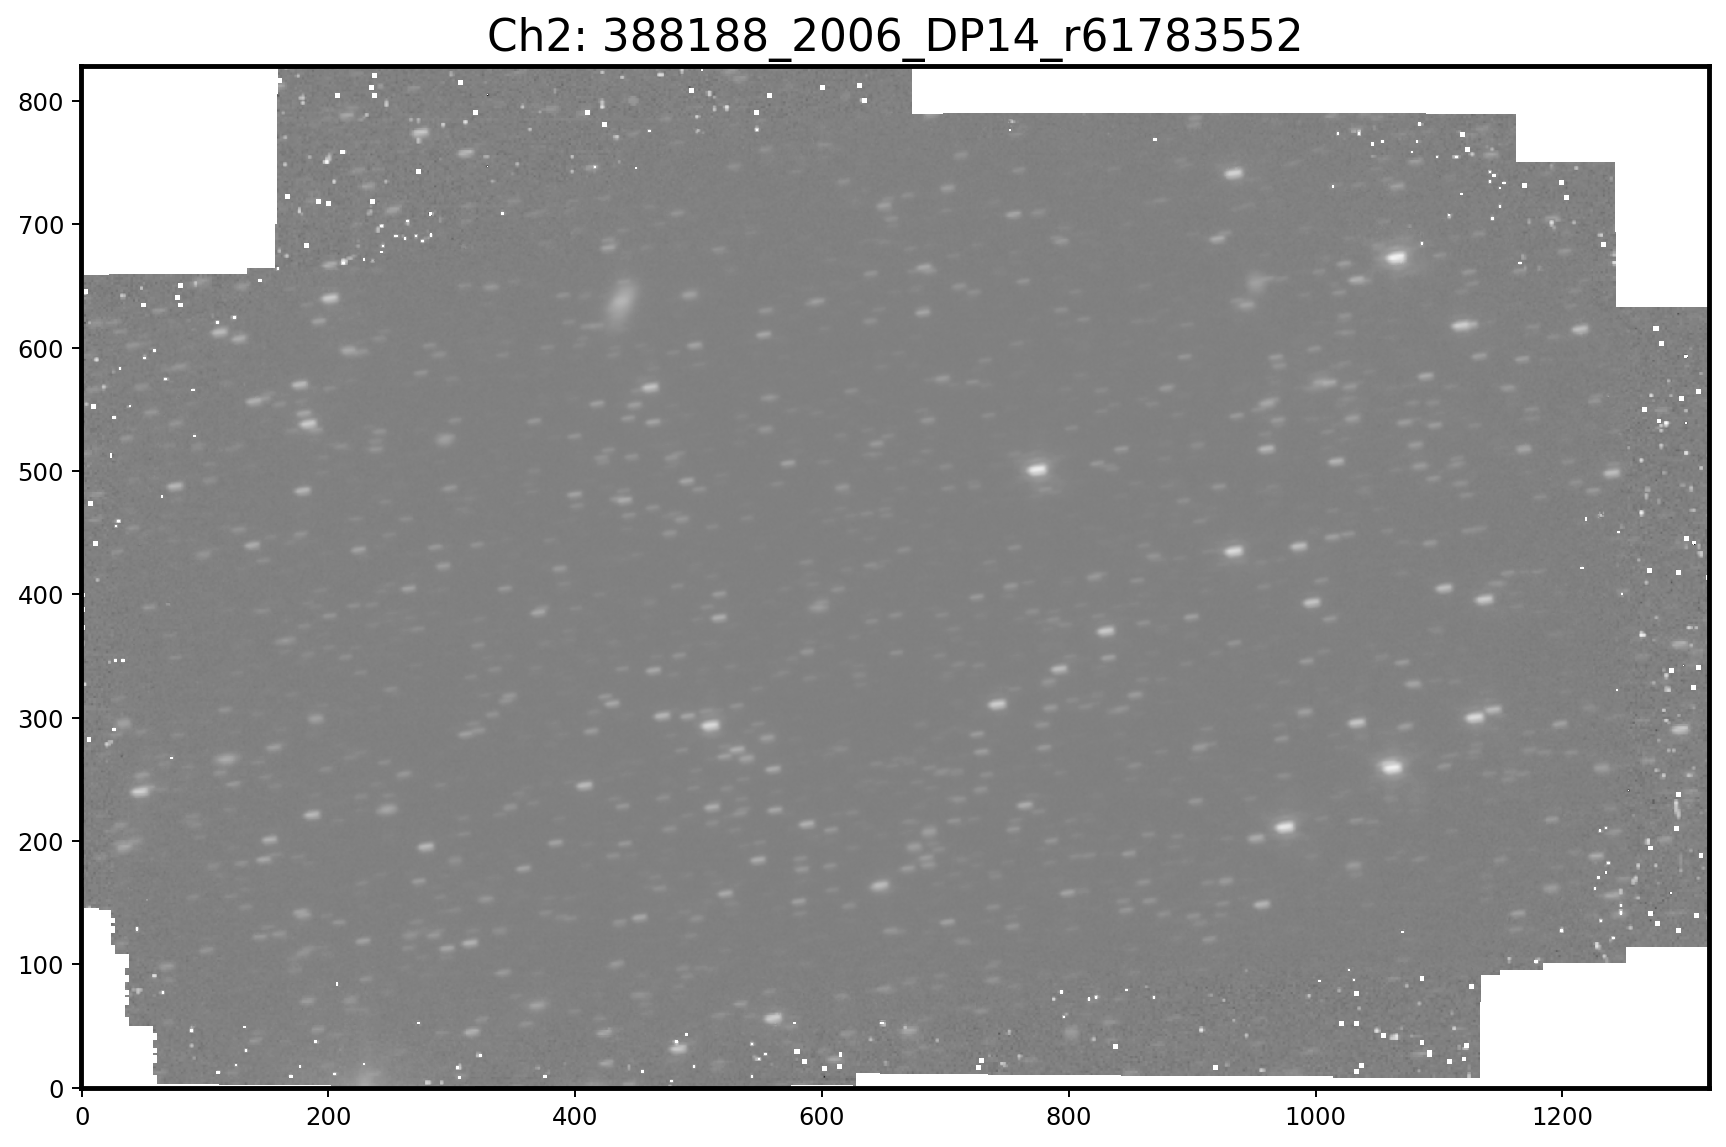

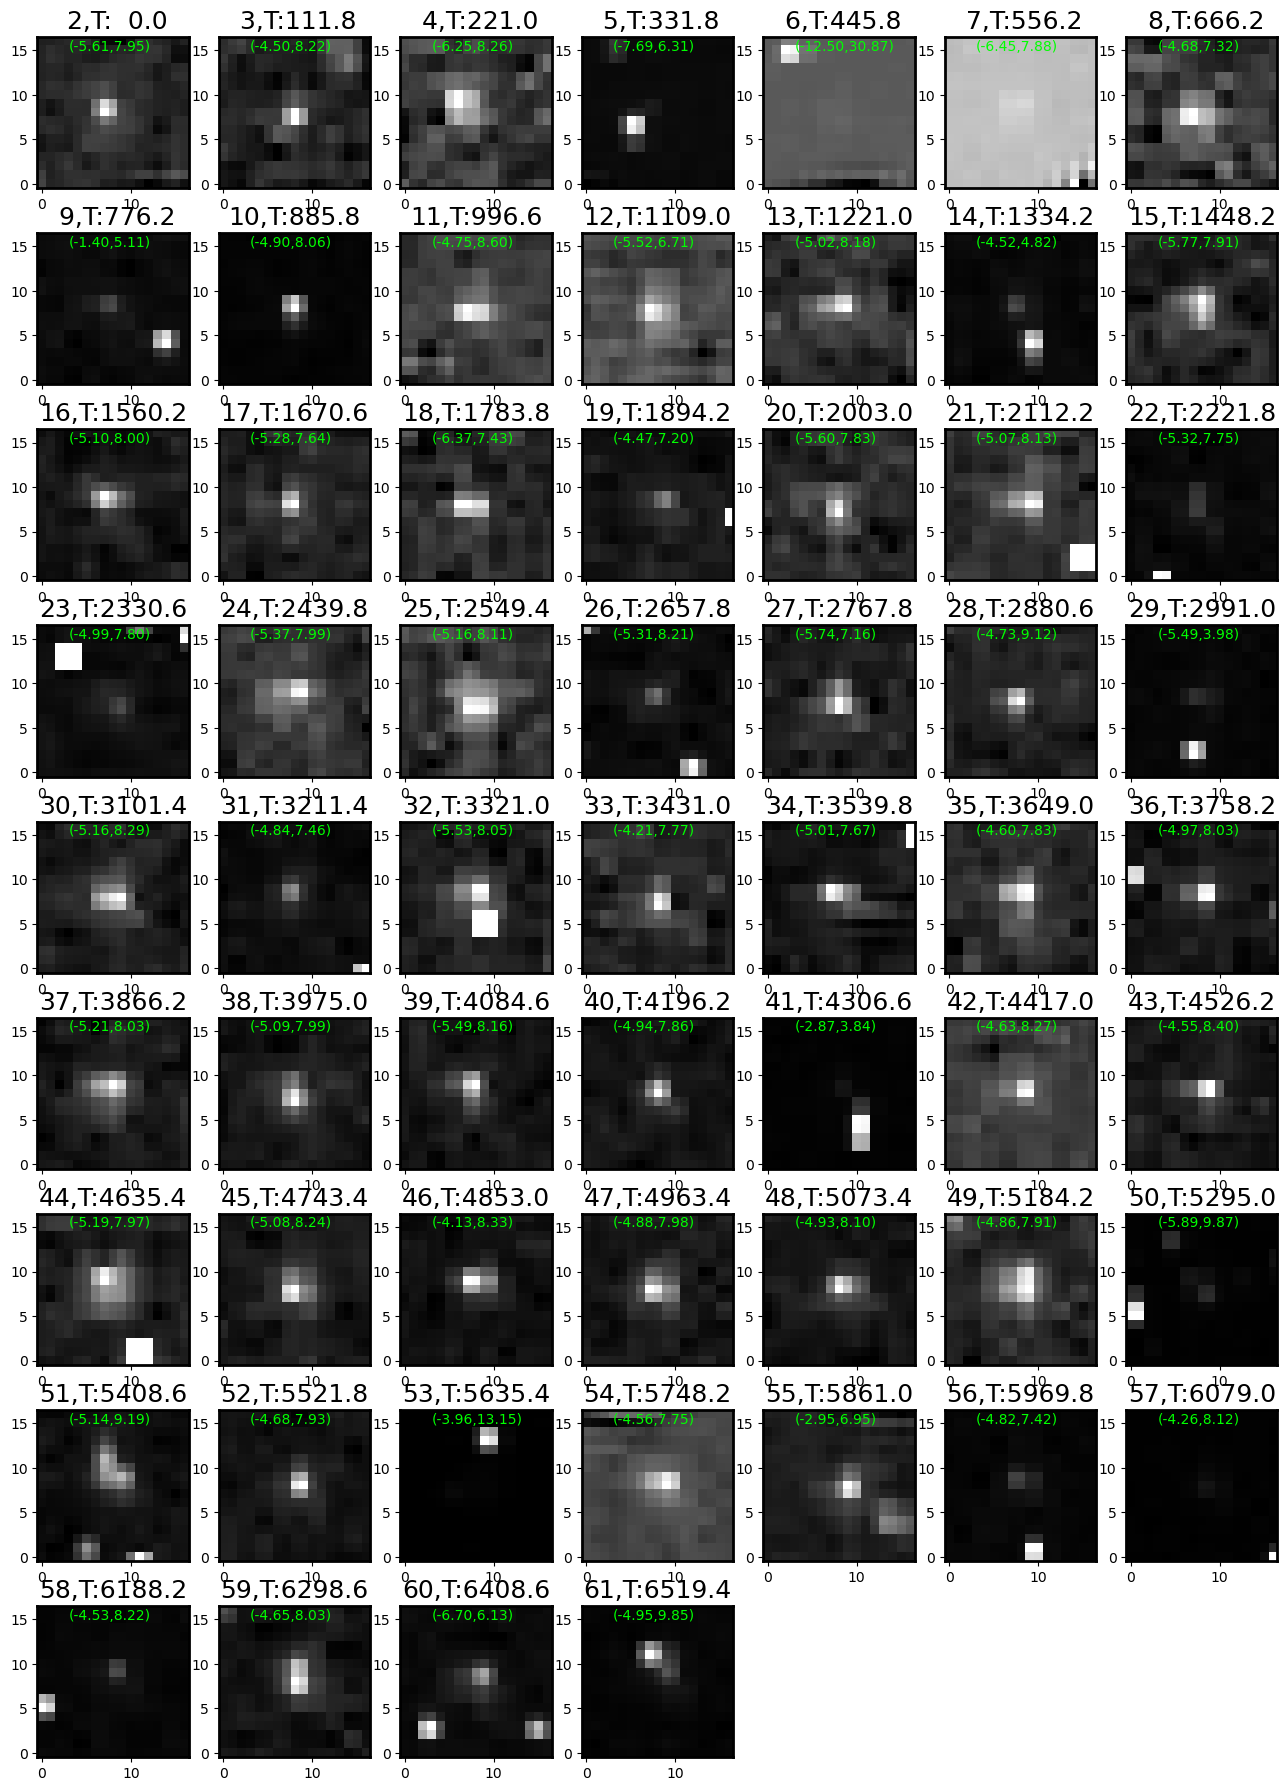

Ch2 median shift:  -5.00,   7.98 


In [101]:
# Perform the Ch2 photometry, display cutouts of the BCD frames around the NEO

%matplotlib inline

photlist2, times2, fluxes2, badtimes2, badflux2, xreloff2, yreloff2, xshift2, yshift2, errest2 = get_BCDphot(subframelist2,
                    firstboxsize, mshift, do_mult_mos, impath, objectname, mosnum, logfile)

added bad time  331.84512031730264
added bad time  776.2435202021152
added bad time  885.8419199008495
added bad time  1334.2320000054315
added bad time  2991.021120012738
added bad time  4306.608000118285
added bad time  5294.998080097139
added bad time  5408.605440147221
added bad time  5635.388160101138
added bad time  5860.995839908719
added bad time  5969.799360469915
added bad time  6188.192640035413
added bad time  6408.590400405228
added bad time  6519.389760447666


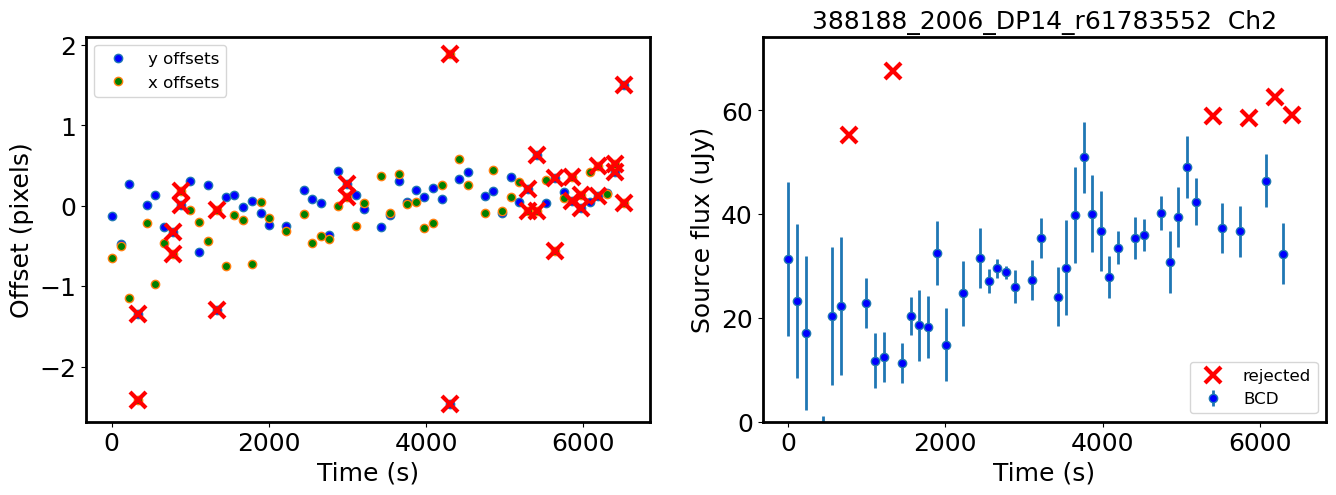

In [102]:
# Evaluate the Ch2 photometry

# This cell can be repeated if one is not satisfied with the results as plotted in this cell

if len(photlist2)>0:
    BCDphot2, errest2, gxro2, gyro2, badtimes2, badflux2 = eval_phot(photlist2, times2, fluxes2, 
        badtimes2, badflux2, xreloff2, yreloff2, objectname,2, xshift2, yshift2, do_mult_mos, impath)
else:
    print("Error - no valid Ch2 photometry.")

gxro2 = np.asarray(gxro2) * float(pixelscales[0])
gyro2 = np.asarray(gyro2) * float(pixelscales[1])
distrads2 = np.sqrt(gxro2**2 + gyro2**2)
disterr2 = np.std(distrads2)


In [103]:
# Write results to files

print("Ch2 position error: ", str("%5.3f" % disterr2))
logfile.write("Ch2 position error: "+str("%5.3f\n" % disterr2))
outfile = impath + objectname + "_ch2.csv"
if do_mult_mos:
    goodfluxes2, raoffsets2, decoffsets2 = write_BCDphot_output(outfile, BCDphot2, errest2,
                                                                objectname, SPK, 2, overwrite=False)
else:
    goodfluxes2, raoffsets2, decoffsets2 = write_BCDphot_output(outfile, BCDphot2, errest2,
                                                                objectname, SPK, 2)
if len(goodfluxes2)>0:
    BCDphotmean2 = np.mean(goodfluxes2)
    BCDphotstd2 = np.std(goodfluxes2)
    outline = "Ch2 mean BCD flux: "+str("%6.3f " % BCDphotmean2)+str(" std: %5.3f" % BCDphotstd2)
    print('\n\n',outline)
    print(" Ch2 mean BCD mag: " + str("%5.3f, err=" % uJy2mag(2,BCDphotmean2)),
          str("%4.2f" % (BCDphotstd2/BCDphotmean2)))
    logfile.write(outline + '\n\n')
    ramedoff = np.median(raoffsets2)
    decmedoff = np.median(decoffsets2)
    rastdoff = np.std(raoffsets2)
    decstdoff = np.std(decoffsets2)
    outline = " Ch2 RA median offset: "+ str("%6.3f " % ramedoff) + str(" std: %5.3f" % rastdoff)
    print(outline)
    logfile.write(outline + '\n')
    outline = " Ch2 Dec median offset: "+ str("%6.3f " % decmedoff) + str(" std: %5.3f" % decstdoff)
    print(outline)
    logfile.write(outline + '\n')
else:
    BCDphotmean2 = 0
    BCDphotstd2 = 0
    outline = 'No Ch2 BCD photometry results'
    print('\n\n',outline)
    logfile.write(outline + '\n\n')


Ch2 position error:  0.361


C:\Users\Joseph Hora\NEOphot_funcs.py:960: UserWarning: Warning: converting a masked element to nan.
  times.append(otime)




 Ch2 mean BCD flux: 28.694  std: 11.632
 Ch2 mean BCD mag: 16.993, err= 0.41
 Ch2 RA median offset:  1.581  std: 0.232
 Ch2 Dec median offset:  5.514  std: 0.133


stderr:  0.14714370052342673 , 0.1346580553013377  arcsec


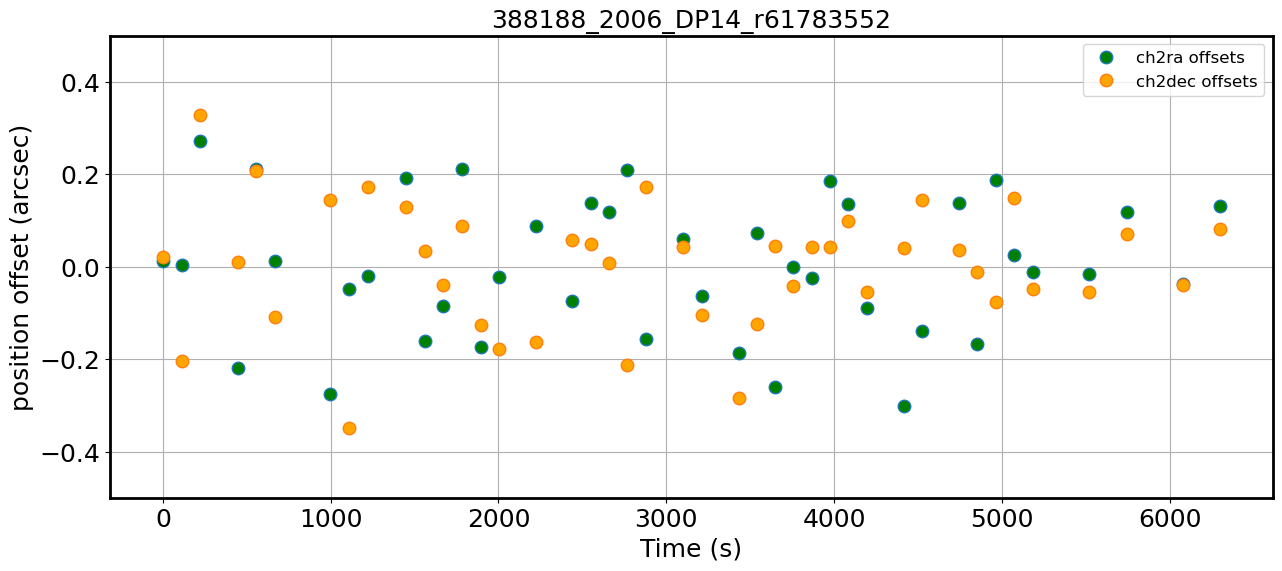

74

In [104]:


if bothchan:
    rastd, decstd = plotRA_DEC(BCDphot1, BCDphot2, do_mult_mos, impath, objectname, mosnum)
else:
    rastd, decstd = plotRA_DECch2(BCDphot2, do_mult_mos, impath, objectname, mosnum)
logfile.write("\nstd from linear position fit: \n"+
              str("  RA:  %6.3f arcsec\n" % rastd)+str("  Dec: %6.3f arcsec\n" % decstd))

## Calculate NEO mosaic without rejected frames
Redo the NEO mosaic construction excluding the frames that were rejected in the above evaluation step.

42  frames to be coadded
310.546966774851 -39.1337291501483


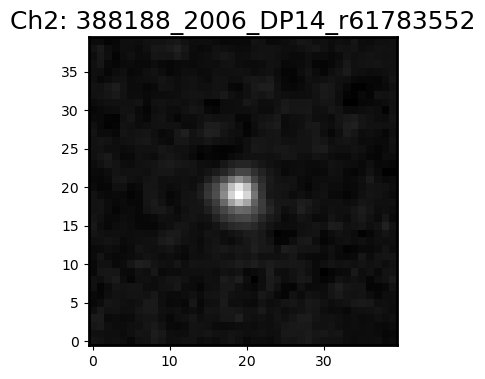

In [105]:
# Make mosaic of NEOs from sky-subtracted frames
useallBCDs = False                          # Do not use the frames that have been rejected when making mosaic
# useallBCDs = True                         # This will use all of the frames, including those rejected in the above steps
moswl = 301

if bothchan:
    BCD1list = []
    for i in range(len(BCDphot1)):
        BCD1list.append(BCDphot1[i][0])
    refnum1 = int(len(BCD1list)/2) +1
BCD2list = []
for i in range(len(BCDphot2)):
    BCD2list.append(BCDphot2[i][0])
refnum2 = int(len(BCD2list)/2) +1

if useallBCDs:
    if bothchan:
        BCD1list = subframelist1.copy()
    BCD2list = subframelist2.copy()

debug=False                                # write out extra diagnostic files
recenter = False                           # recenter BCDs before constructing NEO mosaic 
# recenter = True                          # recenter BCDs before constructing NEO mosaic? 

if recenter:
    logfile.write("Recentering BCDs based on image centroid to make NEO mosaic\n")
else:
    logfile.write("No recentering of BCDS to make NEO mosaic\n")
rootname = impath + objectname
if bothchan:
    if do_mult_mos:
        I1mosname = rootname + '_I1mos' + str('_%1i' % mosnum) + '.fits'
    else:
        I1mosname = rootname + '_I1mos.fits'
    ch1NEOimage, ch1NEOframes = make_NEOmosaic(BCD1list, I1mosname, refnum1, std_base,
                                    recenter, xshift2, yshift2, logfile, moswl, objectname, versionnum, versiondate)
else:
    ch1NEOimage = ""
if do_mult_mos:
    I2mosname = rootname + '_I2mos' + str('_%1i' % mosnum) + '.fits'
else:
    I2mosname = rootname + '_I2mos.fits'
# xshift2 = -xshift2
useallBCDs = False                         # This will use all of the frames, including those rejected in the above steps

# yshift2 = -yshift2
# recenter = True              # control channel 2 recentering if different from channel 1
ch2NEOimage, ch2NEOframes = make_NEOmosaic(BCD2list, I2mosname, refnum2, std_base,
                                recenter, xshift2, yshift2, logfile, moswl, objectname, versionnum, versiondate)

plotNEOmosaics(ch1NEOimage, ch2NEOimage, bothchan, std_base, impath, objectname, mosnum, do_mult_mos)

Positions:  (150.11845648253993, 149.95748317107046)
 id  xcenter   ycenter  ... annulus_median   aper_bkg  aper_sum_bkgsub
       pix       pix    ...                                           
--- --------- --------- ... -------------- ----------- ---------------
  1 149.97261 150.05342 ...  0.00040252485 0.080932423       2.8771627
Ch2 Flux:   27.722 uJy, err=46.279 uJy
Ch2 mag: 17.031, err= 1.67


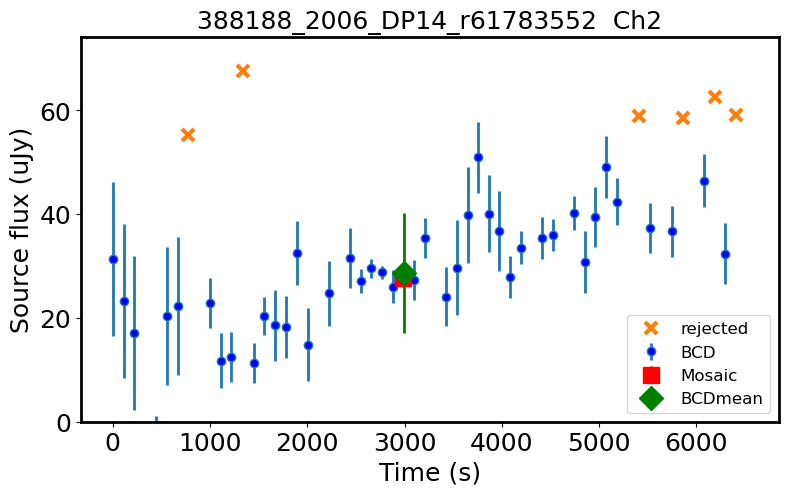

In [106]:
# Perform photometry on the NEO mosaics

Iphot2, Iphot2err, I2ra, I2dec = get_mosaicphot(I2mosname, moswl)
if bothchan:
    Iphot1, Iphot1err, I1ra, I1dec = get_mosaicphot(I1mosname)
    ch1mosunc = BCDphotstd1/np.sqrt(len(ch1NEOframes))
    print("Ch1 Flux:" + str(" %8.3f uJy, err=" % Iphot1) + str("%5.3f uJy" % Iphot1err))
    print("Ch1 mag: " + str("%5.3f, err=" % uJy2mag(1,Iphot1)), str("%4.2f" % (Iphot1err/Iphot1)))

print("Ch2 Flux:" + str(" %8.3f uJy, err=" % Iphot2) + str("%5.3f uJy" % Iphot2err))
print("Ch2 mag: " + str("%5.3f, err=" % uJy2mag(2,Iphot2)), str("%4.2f" % (Iphot2err/Iphot2)))

ch2mosunc = BCDphotstd2/np.sqrt(len(ch2NEOframes))
if bothchan:
    plot_phot(BCDphot1, 1, Iphot1, ch1mosunc,  BCDphotmean1,  BCDphotstd1, badtimes1, 
              badflux1, do_mult_mos, mosnum, objectname, impath, show=True)
plot_phot(BCDphot2, 2, Iphot2, ch2mosunc, BCDphotmean2,  BCDphotstd2, badtimes2, badflux2,
          do_mult_mos, mosnum, objectname, impath, show=True)

In [107]:
# Write redone photometry out to file

if do_mult_mos:
    outfile = impath + objectname + "_mosphot"+ str('_%1i' % mosnum)+".csv"
else:
    outfile = impath + objectname + '_mosphot.csv'
if os.path.exists(outfile):
    os.remove(outfile)
logfile.write("\nNEO mosaic photometry from mosaics excluding rejected BCDs:\n")
if bothchan:
    photlst = []
    errest = []
    print("Ch1 Flux:" + str(" %8.3f uJy, err=" % Iphot1) + str("%5.3f uJy" % ch1mosunc))
    logfile.write(" Ch1 Flux:" + str(" %8.3f uJy, err=" % Iphot1) + str("%5.3f uJy\n" % ch1mosunc))
    photline = (I1mosname, getval(I1mosname, 'MJD_OBS'), I1ra,I1dec, Iphot1,
                ch1mosunc, getval(I1mosname, 'DATE_OBS'))
    photlst.append(photline)
    errest.append(ch1mosunc)
    goodmos1, mosraoff, mosdecoff = write_BCDphot_output(outfile,
                                                         photlst, errest, objectname, SPK, 1)
photlst = []
errest = []

print("Ch2 Flux:" + str(" %8.3f uJy, err=" % Iphot2) + str("%5.3f uJy" % ch2mosunc))
logfile.write(" Ch2 Flux:" + str(" %8.3f uJy, err=" % Iphot2) + str("%5.3f uJy\n" % ch2mosunc))
photline = (I2mosname, getval(I2mosname, 'MJD_OBS'), I2ra, I2dec, Iphot2, ch2mosunc, getval(I2mosname, 'DATE_OBS'))
photlst.append(photline)
errest.append(ch2mosunc)
if bothchan:
    goodmos1, mosraoff, mosdecoff = write_BCDphot_output(outfile, photlst, errest,
                                                         objectname, SPK, 2, overwrite=False)
else:
    goodmos1, mosraoff, mosdecoff = write_BCDphot_output(outfile, photlst, errest,
                                                         objectname, SPK, 2)
    
if do_mult_mos:
    mosnum = mosnum + 1
    if mosnum == number_of_mosaics:
        mosnum = 0
        print("Finished with final mosaic, proceed to next object")
    else:
        print("Proceed to next mosaic in set (", str("%1i of " % (mosnum+1)), str("%1i)" % number_of_mosaics))

Ch2 Flux:   27.722 uJy, err=1.795 uJy


In [108]:
# Close out log file and copy results to the results directory, set up next AOR to process

if not do_mult_mos or mosnum == 0:
    logfile.close()
    copy_results()
    if bothchan:
        clean_datadir(impath + 'ch1/bcd/*rpro.fits')
        clean_datadir(impath + 'ch1/bcd/*rpro_sub.fits')
    clean_datadir(impath + 'ch2/bcd/*rpro.fits')
    clean_datadir(impath + 'ch2/bcd/*rpro_sub.fits')


#  Set up next AOR to process by going to next directory in AOR list

    AORdirname = rootdir[:(len(rootdir)-1)]+'/'+AORcode          # Find the current directory being processed
    try:
        curindex = AORlist.index(AORdirname)
        if curindex<len(AORlist)-1:
            nextAORdir = AORlist[curindex+1]                              # get next directory in list
            nextAOR = nextAORdir[(nextAORdir.rfind('/')+1):]              # strip out the AOR subdirectory name
            print("next AOR to process: ",nextAOR, ", ", curindex," of ", len(AORlist), " objects")
        else:
            print("Completed AOR list")

        with open('nextAORdir.txt', 'w') as nextAORfile:
            nextAORfile.write(nextAOR)
    except:
        print('Current AOR not in list of objects')
else:
    print('Not yet done with multiple mosaics!')

next AOR to process:  r61783808 ,  9  of  916  objects


# End of processing

If there is a "next AOR to process", click on the link below to start the next AOR reduction

[Jump to Start Processing](#StartProcessing)

## If you need to reopen the log file or close it, use the following commands

In [ ]:
logfile = open(impath + objectname + "_info.log", "a")

In [109]:
logfile.close()

## Mosaic Calculation Tool to determine offset

If the NEO is too far from predicted position, use the below routine to see where it is and set the mshift parameter

The routine below makes a mosaic of the sky-subtracted Ch2 frames so you can see a faint NEO where it is not
visible in single frames in the nominal process. Then copy the mshift values and use them for Sky Mosaic Calculation
above

In [96]:
testBCDlist = subframelist2.copy()

debug=False                              # write out extra diagnostic files
recenter = False                           # recenter BCDs before constructing NEO mosaic 

rootname = impath + objectname
Itmosname = rootname + '_testmos.fits'
moswl = 301
xshift = 0
yshift = 0
testimage, testframes = make_NEOmosaic(testBCDlist, Itmosname, 0, std_base, recenter,
                                       xshift, yshift, logfile, moswl, objectname, versionnum, versiondate)
# Find mshift value 

    
matplotlib.use('Qt5Agg')

image = Itmosname
xNEOoff = 0
yNEOoff = 0
# image = rootdir+AORcode+'/ch2/bcd/SPITZER_I2_61808640_0063_0000_1_rpro_sub.fits'
hdr = getheader(image)

w = WCS(hdr)
image_data = getdata(image)
mean, median, std = sigma_clipped_stats(image_data, sigma=3.0)  
fig = plt.figure(figsize=(16,16))
ax=plt.subplot(projection=w)
cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.title(image)
xref = moswl/2
yref = moswl/2
plt.imshow(image_data, cmap='gray', origin='lower', vmin=max(0.000001,median-std), vmax=5*std)
plt.plot(xref, yref, linestyle="None",marker='+',markerfacecolor='red', markeredgecolor = 'red', markersize=15)
pts = plt.ginput(1, timeout = -1)   #number of clicks
print("x:",pts[0][0], pts[0][1])
plt.close()
mshift = ((pts[0][0]-xref),(pts[0][1]-yref))
print(mshift)

60  frames to be coadded
310.551911912763 -39.1330919951819
single click: button=1, x=1410, y=1065, xdata=145.362096, ydata=158.248844
x: 145.36209553158704 158.24884437596302
(-5.137904468412955, 7.748844375963017)


### Below you can look at one image in set to find NEO in frame

In [95]:
# Find mshift value 
def onclick(event):
    print('%s click: button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
          ('double' if event.dblclick else 'single', event.button,
           event.x, event.y, event.xdata, event.ydata))
    
matplotlib.use('Qt5Agg')

image = subframelist2[int(len(subframelist2)/2)-3]
xNEOoff = 0
yNEOoff = 0
# image = rootdir+AORcode+'/ch2/bcd/SPITZER_I2_61808640_0063_0000_1_rpro_sub.fits'
hdr = getheader(image)
w = WCS(hdr)
image_data = getdata(image)
mean, median, std = sigma_clipped_stats(image_data, sigma=3.0)  
raref = hdr['RA_REF']
decref = hdr['DEC_REF']
xref, yref = w.wcs_world2pix(raref, decref, 1)
image_data = image_data - median
position = (xref+xNEOoff, yref+yNEOoff)
position = (int(image_data.shape[1]/2), int(image_data.shape[0]/2))
winsize = (900,900)
imcut = Cutout2D(image_data, position=position, size=winsize, wcs=w)
cutframe = imcut.data
xref, yref = imcut.wcs.wcs_world2pix(raref, decref, 1)
fig = plt.figure(figsize=(12,12))
ax=plt.subplot(projection=imcut.wcs)
cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.title(image)
plt.imshow(cutframe, cmap='gray', origin='lower', vmin=max(0.000001,median-std), vmax=5*std)
plt.plot(xref, yref, linestyle="None",marker='+',markerfacecolor='red', markeredgecolor = 'red', markersize=15)
pts = plt.ginput(1, timeout = -1)   #number of clicks
print("x:",pts[0][0], pts[0][1])
plt.close()
mshift = ((pts[0][0]-xref),(pts[0][1]-yref))
print(mshift)

single click: button=1, x=1100, y=1004, xdata=463.048387, ydata=404.225806
x: 463.04838709677426 404.2258064516129
(1.1601018250574953, 0.04170142785534381)
